In [1]:
import pandas as pd
import os
from data_preprocessing import preprocess_dataframe
from descriptor_calculation import descriptor_cal

In [2]:

descriptor_list= ["Morgan fingerprints","MACCSKeysFingerprint","RDKitDescriptors"] 


In [3]:

# read data
df = pd.read_csv("All Properties with Finguprints_3.csv")


In [4]:

# drop duplicates and encodes taget
df = preprocess_dataframe(df) # smiles , target 
print(f"shape of df after preprocessing: {df.shape}")

shape of df after preprocessing: (11986, 2)


In [5]:
df.head()

,Smiles,target
0,N#Cc1cc2ccc(O)cc2oc1=O,1
1,N#Cc1cc2ccc([O-])cc2oc1=O,1
2,CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(=O)c2ccc3c4ccc5c...,1
3,[O-]c1c(-c2nc3ccccc3s2)cc2ccc3cccc4ccc1c2c34,1
5,CCN(CC)c1ccc2c(C)cc(=O)oc2c1,1


In [5]:
df.tail()

,Smiles,target
16029,FC(F)(F)C1=CN(CC2=CSC(NC3=CC=CC=C3)=N2)C(=O)C=C1,0
22764,O=C(C1CCCCC1)N1CCC2=CC(=CC=C12)S(=O)(=O)N1CCCCC1,0
17704,CC1=C(N=C(O1)C1=CC=CC=C1)C(=O)N1CCCC2=C(F)C=C(...,0
21554,O=C(NC1CCN(CC2CCCC2)C1)C1CN(C(=O)C1)C1=CC=CC=N1,0
29459,CC1=CC=C(C)C(=C1)C1=NC(CCN2N=NC3=CC=CC=C23)=NO1,0


In [9]:
df["target"].value_counts()

1    5993
0    5993
Name: target, dtype: int64

In [ ]:
# Loop through the list of descriptors
for descriptor in descriptor_list:
    # Call the descriptor_cal function to get X and Y
    X, Y = descriptor_cal(df, descriptor)
    
    # Create a folder for the descriptor if it doesn't exist
    folder_path = os.path.join(os.getcwd(),"Smiles_Descriptors", f"{descriptor}")
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Save the X and Y DataFrames to separate CSV files in the folder
    x_file_path = os.path.join(folder_path, 'X.csv')
    y_file_path = os.path.join(folder_path, 'Y.csv')
    X.to_csv(x_file_path, index=False)
    Y.to_csv(y_file_path, index=False)

    print(f"X and y saved for {descriptor}")
    print(f"descriptors shape: {X.shape}")

### Train Models

In [10]:
from train_func import train_models
import shutil
import os
import pandas as pd

# Define the path to the folder containing subfolders
path_to_descriptors = "Smiles_Descriptors" # path to descriptors folder
results_folder = "ClassificationScores"
if os.path.exists(results_folder):
    shutil.rmtree(results_folder)



# Loop over each subfolder
for subfolder_name in os.listdir(path_to_descriptors):
    
    # Define the path to the X.csv and Y.csv files for the current subfolder
    path_to_X = os.path.join(path_to_descriptors, subfolder_name, "X.csv")
    path_to_Y = os.path.join(path_to_descriptors, subfolder_name, "Y.csv")
    
    # Load the X.csv and Y.csv files as dataframes
    X = pd.read_csv(path_to_X)
    Y = pd.read_csv(path_to_Y)
    
    # Call the train_models function with X, Y, and the current subfolder name as the PATH argument
    train_models(X, Y, f"{results_folder}/{subfolder_name}")

/Users/ganeshjadhav/opt/anaconda3/envs/ML-for-LSD1-main/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ganeshjadhav/opt/anaconda3/envs/ML-for-LSD1-main/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ganeshjadhav/Desktop/Fluorescent_compound_prediction/train_func.py:53: DataConversionWarning: A column-vector y was passed when a 1

### Plot scores

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

def plot_metrics(SCORES_FOLDER,METRIC_TO_PLOT):
        
    # Define a list to store the accuracy values for each csv file
    accuracy_values = []

    # Loop through each subfolder in folder1
    for subfolder in os.listdir(SCORES_FOLDER):
        subfolder_path = os.path.join(SCORES_FOLDER, subfolder)
        
        # Loop through each csv file in the subfolder
        for csv_file in os.listdir(subfolder_path):
            if csv_file.endswith('.csv'):
                csv_path = os.path.join(subfolder_path, csv_file)
                
                # Read the csv file into a pandas dataframe
                df = pd.read_csv(csv_path, index_col=[0])
                
                # Extract the accuracy value from the dataframe and append it to the list
                accuracy_value = df.loc[METRIC_TO_PLOT].values[0]
                accuracy_values.append((subfolder, csv_file[:-4], accuracy_value)) # Remove the last 4 characters (i.e. ".csv") from the csv file name

    # Convert the accuracy values list to a pandas dataframe
    df_accuracy = pd.DataFrame(accuracy_values, columns=['Subfolder', 'CSV File', METRIC_TO_PLOT])

    # Pivot the dataframe to have Subfolder as the index, CSV File as the columns, and Accuracy as the values
    df_accuracy_pivot = df_accuracy.pivot(index='Subfolder', columns='CSV File', values=METRIC_TO_PLOT)

    # Create a plot of the accuracy values
    plt.figure(figsize=(10, 5))
    for csv_file in df_accuracy_pivot.columns:
        plt.plot(df_accuracy_pivot.index, df_accuracy_pivot[csv_file], label=csv_file[:]) # Remove the last 4 characters (i.e. ".csv") from the csv file name
    plt.xlabel('Subfolder')
    plt.ylabel(METRIC_TO_PLOT)
    plt.legend()

    # Get the current date and time and format it for the filename
    now = datetime.datetime.now()

    # Define the path and filename for the plot
    plot_path = f'{SCORES_FOLDER[:-6]}plots'
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)
        
    plot_name = os.path.join(plot_path, METRIC_TO_PLOT)

    # Save the plot
    plt.savefig(plot_name)

    # Show the plot
    plt.show()

    print(f"Compairison plots saved at: {plot_path}")

    return df_accuracy

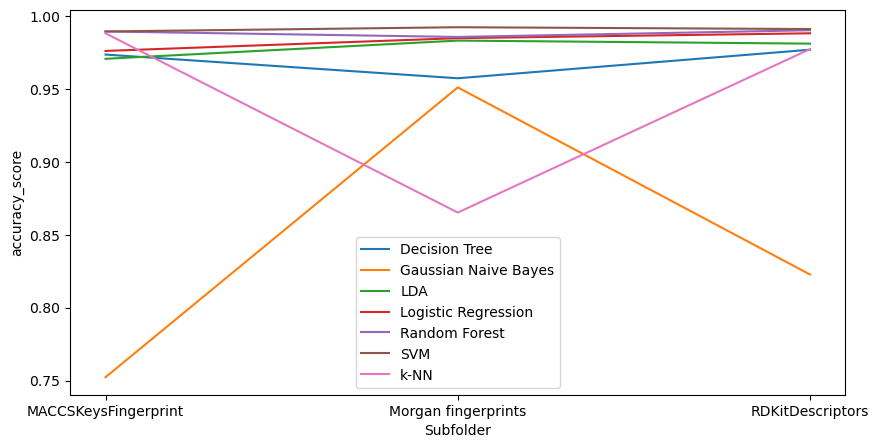

Compairison plots saved at: Classificationplots


,Subfolder,CSV File,accuracy_score
0,MACCSKeysFingerprint,k-NN,0.988324
1,MACCSKeysFingerprint,Random Forest,0.989575
2,MACCSKeysFingerprint,LDA,0.970809
3,MACCSKeysFingerprint,Gaussian Naive Bayes,0.752294
4,MACCSKeysFingerprint,Logistic Regression,0.976230
5,MACCSKeysFingerprint,Decision Tree,0.973728
6,MACCSKeysFingerprint,SVM,0.989575
7,RDKitDescriptors,k-NN,0.977481
8,RDKitDescriptors,Random Forest,0.990409
9,RDKitDescriptors,LDA,0.981234


In [12]:
SCORES_FOLDER = "ClassificationScores"
METRIC_TO_PLOT = "accuracy_score"
plot_metrics(SCORES_FOLDER,METRIC_TO_PLOT)

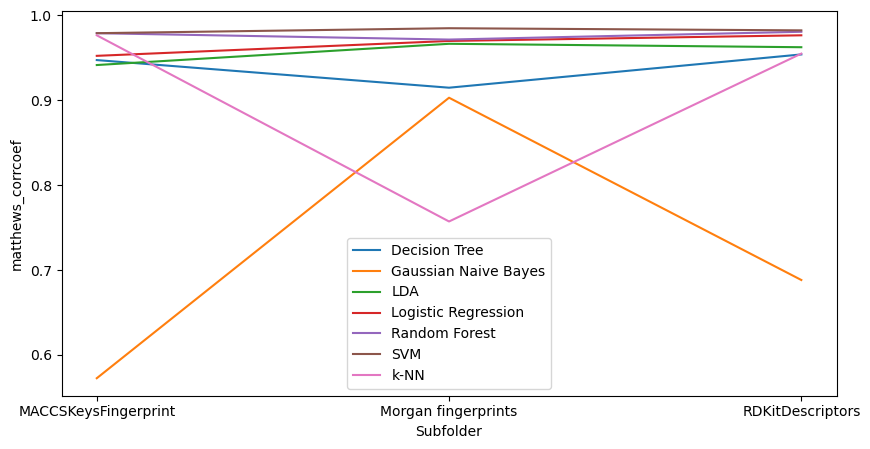

Compairison plots saved at: Classificationplots


,Subfolder,CSV File,matthews_corrcoef
0,MACCSKeysFingerprint,k-NN,0.976651
1,MACCSKeysFingerprint,Random Forest,0.979144
2,MACCSKeysFingerprint,LDA,0.941610
3,MACCSKeysFingerprint,Gaussian Naive Bayes,0.572506
4,MACCSKeysFingerprint,Logistic Regression,0.952459
5,MACCSKeysFingerprint,Decision Tree,0.947462
6,MACCSKeysFingerprint,SVM,0.979144
7,RDKitDescriptors,k-NN,0.955095
8,RDKitDescriptors,Random Forest,0.980813
9,RDKitDescriptors,LDA,0.962617


In [14]:
SCORES_FOLDER = "ClassificationScores"
METRIC_TO_PLOT = "matthews_corrcoef"
plot_metrics(SCORES_FOLDER,METRIC_TO_PLOT)